Teste de SOM usando <a href="https://en.wikipedia.org/wiki/Democracy_Index">Democracy Index data</a> - Wikipedia.

In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import util
from pathlib import Path
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from class_manipulates_path import ManipulatePath
from class_preprocessing_refactor import Preprocessing
from class_format_data import FormatData

from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
util.init()

'Módulo util importado com sucesso.'

In [2]:
manipulate_path = ManipulatePath()

preprocessing = Preprocessing()

format_data = FormatData()

path_raw_data = manipulate_path.get_path_raw_data()

In [3]:
df_preprocessing = pd.read_parquet(manipulate_path.get_path_preprocessing_real_data_all_classes())

In [4]:
contagem_classes = df_preprocessing['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_preprocessing) * 100
porcentagem_classes

class
0.0    32.679781
5.0    30.983203
7.0    29.009351
1.0     4.797527
6.0     1.810310
2.0     0.719828
Name: count, dtype: float64

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [6]:
def split_dataframe(df, target_column=None, test_size=0.2, random_state=42):
    if target_column:
        # Se a coluna alvo for fornecida, realizar a divisão estratificada
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        for train_index, test_index in split.split(df, df[target_column]):
            df_1 = df.iloc[train_index]
            df_2 = df.iloc[test_index]
    else:
        # Se a coluna alvo não for fornecida, realizar a divisão simples
        df_1, df_2 = train_test_split(df, test_size=test_size, random_state=random_state)

    return df_1, df_2

In [7]:
df_1, df_2 = split_dataframe(df_preprocessing, target_column='class')

In [8]:
df_2.index

DatetimeIndex(['2017-08-01 05:53:46', '2014-03-16 01:41:10',
               '2018-06-18 13:51:02', '2014-01-24 16:04:09',
               '2014-03-19 20:08:27', '2017-02-27 02:15:44',
               '2018-06-21 03:20:09', '2018-06-20 19:45:26',
               '2018-06-19 11:22:31', '2018-06-17 20:17:16',
               ...
               '2018-04-05 01:59:01', '2014-03-14 18:11:28',
               '2014-03-15 02:24:12', '2017-03-13 16:26:44',
               '2017-02-27 02:14:42', '2018-06-19 18:30:11',
               '2014-01-24 12:13:00', '2018-04-26 14:39:13',
               '2014-03-18 00:42:38', '2018-06-19 10:13:08'],
              dtype='datetime64[ns]', name='timestamp', length=195547, freq=None)

In [9]:
contagem_classes = df_2['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_2) * 100
porcentagem_classes

class
0.0    32.679612
5.0    30.983344
7.0    29.009394
1.0     4.797312
6.0     1.810306
2.0     0.720032
Name: count, dtype: float64

Selecionando os atributos para o SOM

In [10]:
model_input = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']

X = df_2[model_input].values

In [11]:
X # cada linha é um timestamp

array([[1.837356e+07, 1.185254e+02, 2.540790e+06, 7.898877e+01],
       [1.183010e+07, 8.559207e+01, 5.048594e+06, 2.788302e+01],
       [2.064947e+07, 1.182339e+02, 1.034531e+07, 7.089747e+01],
       ...,
       [1.134881e+07, 4.139718e+01, 8.359098e+05, 5.279423e+01],
       [8.063387e+06, 9.789194e+01, 3.571022e+06, 4.340056e+01],
       [2.074756e+07, 1.181609e+02, 1.090224e+07, 7.000407e+01]])

E normalizando os dados!

In [12]:
X = StandardScaler().fit_transform(X)

In [13]:
X

array([[ 0.68150668,  0.67528072, -0.98282127,  1.0766421 ],
       [-0.53398711, -1.14170512, -0.32119726, -1.78673128],
       [ 1.104273  ,  0.65919818,  1.07621439,  0.62329951],
       ...,
       [-0.62339012, -3.58000969, -1.43261308, -0.39099605],
       [-1.23368058, -0.46310111, -0.71101924, -0.91730834],
       [ 1.12249391,  0.65517065,  1.22314703,  0.57324374]])

Treinando o SOM

In [14]:
lr_ordering = 2 #Taxa de aprendizado - Ordering phase
lr_finetuning = 0.2 #Taxa de aprendizado - Finetuning phase

# vizinhança
sigma_ordering = 2
sigma_finetuning = 0.4

topology = "rectangular"

ordering_time = 1000
finetuning_time = 3000

In [15]:
size = 12
som = MiniSom(size, size, len(X[0]), learning_rate = lr_ordering,
              neighborhood_function='gaussian', sigma=sigma_ordering,
              random_seed=1, topology=topology)

som.pca_weights_init(X)
som.train_random(X, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:02 left 
 quantization error: 0.06441248609732819


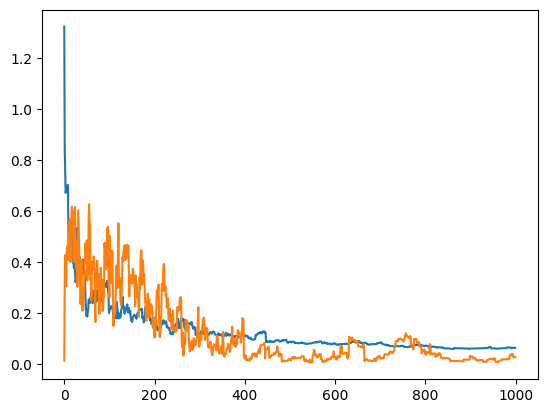

In [16]:
plt.plot(som._quantization_error)
plt.plot(som._topographic_error)

In [17]:
som._learning_rate = lr_finetuning #Para mudar a taxa de aprendizado durante o período de finetuning
som._sigma = sigma_finetuning # Para mudar a vizinhança durante o período de finetuning
som.train_random(X, finetuning_time, verbose=True)

 [ 3000 / 3000 ] 100% - 0:00:02 left 
 quantization error: 0.03874784468781068


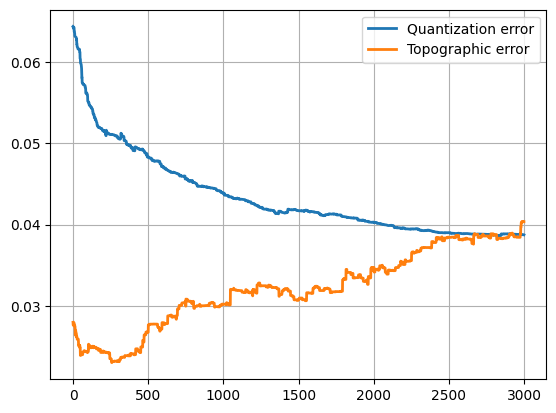

In [18]:
plt.plot(som._quantization_error,linewidth=2,label='Quantization error')
plt.plot(som._topographic_error,linewidth=2, label='Topographic error')
plt.legend()
plt.grid()

Mapa social dos países
----

Com o mapa já treinado, veremos de que forma o mapa está organizado. Para isso, vamos criar um mapa anotando os países correspondentes ao neurônio vencedor. Vamos usar, para isso, as variáveis criadas no início do script.

In [19]:
df_2["LABEL"] = ['R' + str(i+1) for i in range(len(df_2))]

C:\Users\marce\AppData\Local\Temp\ipykernel_2152\728563986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["LABEL"] = ['R' + str(i+1) for i in range(len(df_2))]


In [20]:
df_2["LABEL"]

timestamp
2017-08-01 05:53:46         R1
2014-03-16 01:41:10         R2
2018-06-18 13:51:02         R3
2014-01-24 16:04:09         R4
2014-03-19 20:08:27         R5
                        ...   
2018-06-19 18:30:11    R195543
2014-01-24 12:13:00    R195544
2018-04-26 14:39:13    R195545
2014-03-18 00:42:38    R195546
2018-06-19 10:13:08    R195547
Name: LABEL, Length: 195547, dtype: object

In [21]:
# 0.0    32.679612
# 5.0    30.983344
# 7.0    29.009394
# 1.0     4.797312
# 6.0     1.810306
# 2.0 

In [22]:
category_color = {0: 'darkgreen',
                  1: 'limegreen',
                  2: 'darkorange',
                  5: 'crimson',
                  6: 'dodgerblue',
                  7: 'purple'}
colors_dict = {c: category_color[dm] for c, dm in zip(df_2["LABEL"],
                                                      df_2["class"])}

In [23]:
def shorten_country(c):
    if len(c) > 6:
        return c[:6]
    else:
        return c

country_map = som.labels_map(X, df_2["LABEL"])

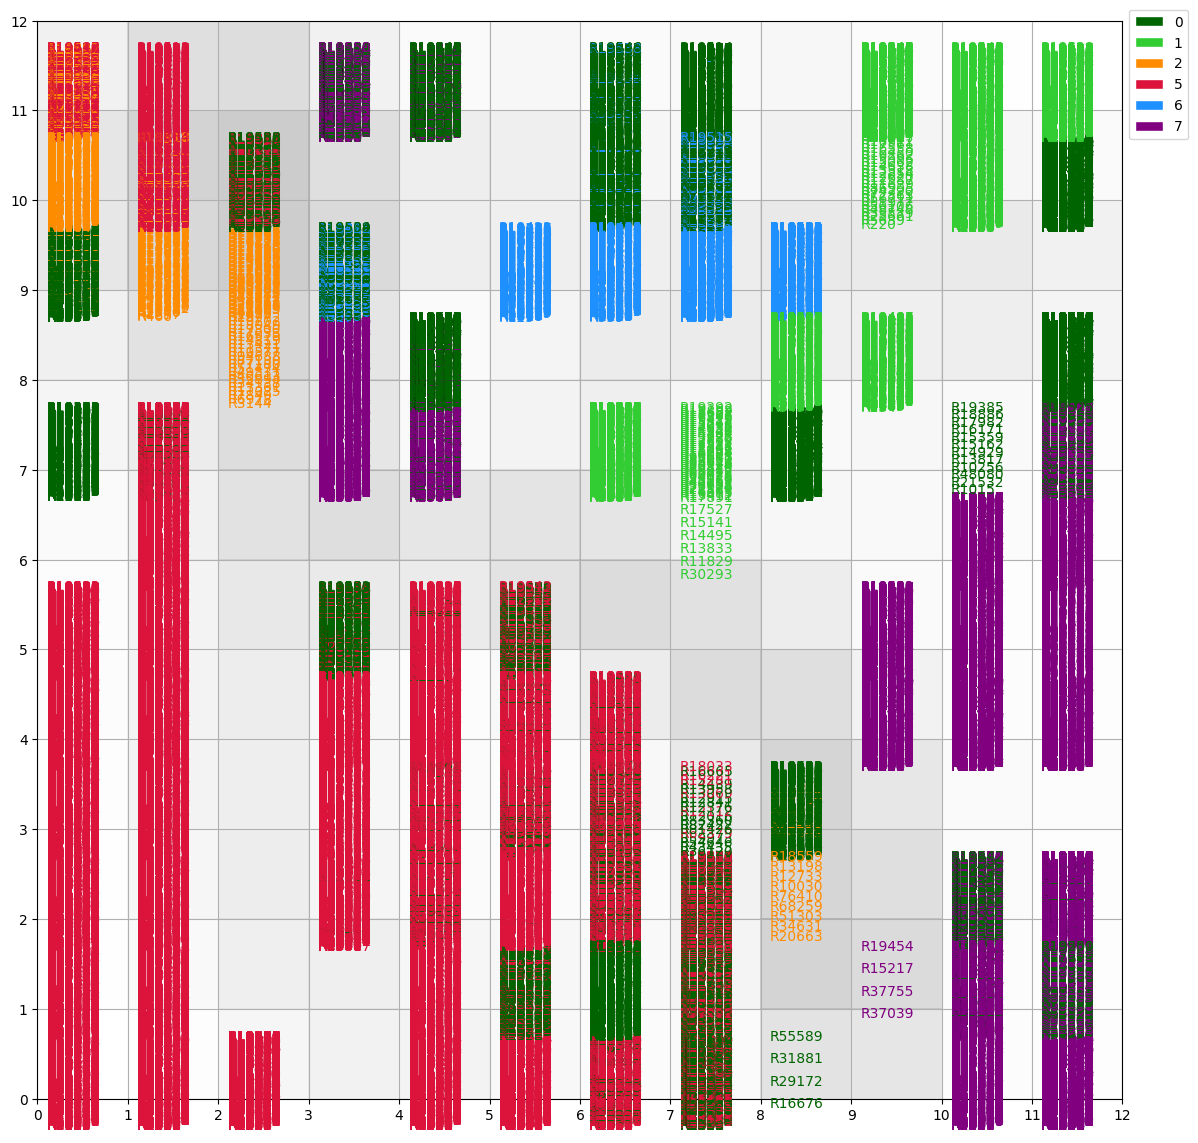

In [24]:
som.plot_winning(country_map,alias_label=shorten_country,colorize=colors_dict,label_color=category_color)

Mapa das variáveis
----

Vamos fazer o mapa para cada uma das características. Iremos ver a magnitude dos pessos associados a cada neurônio.

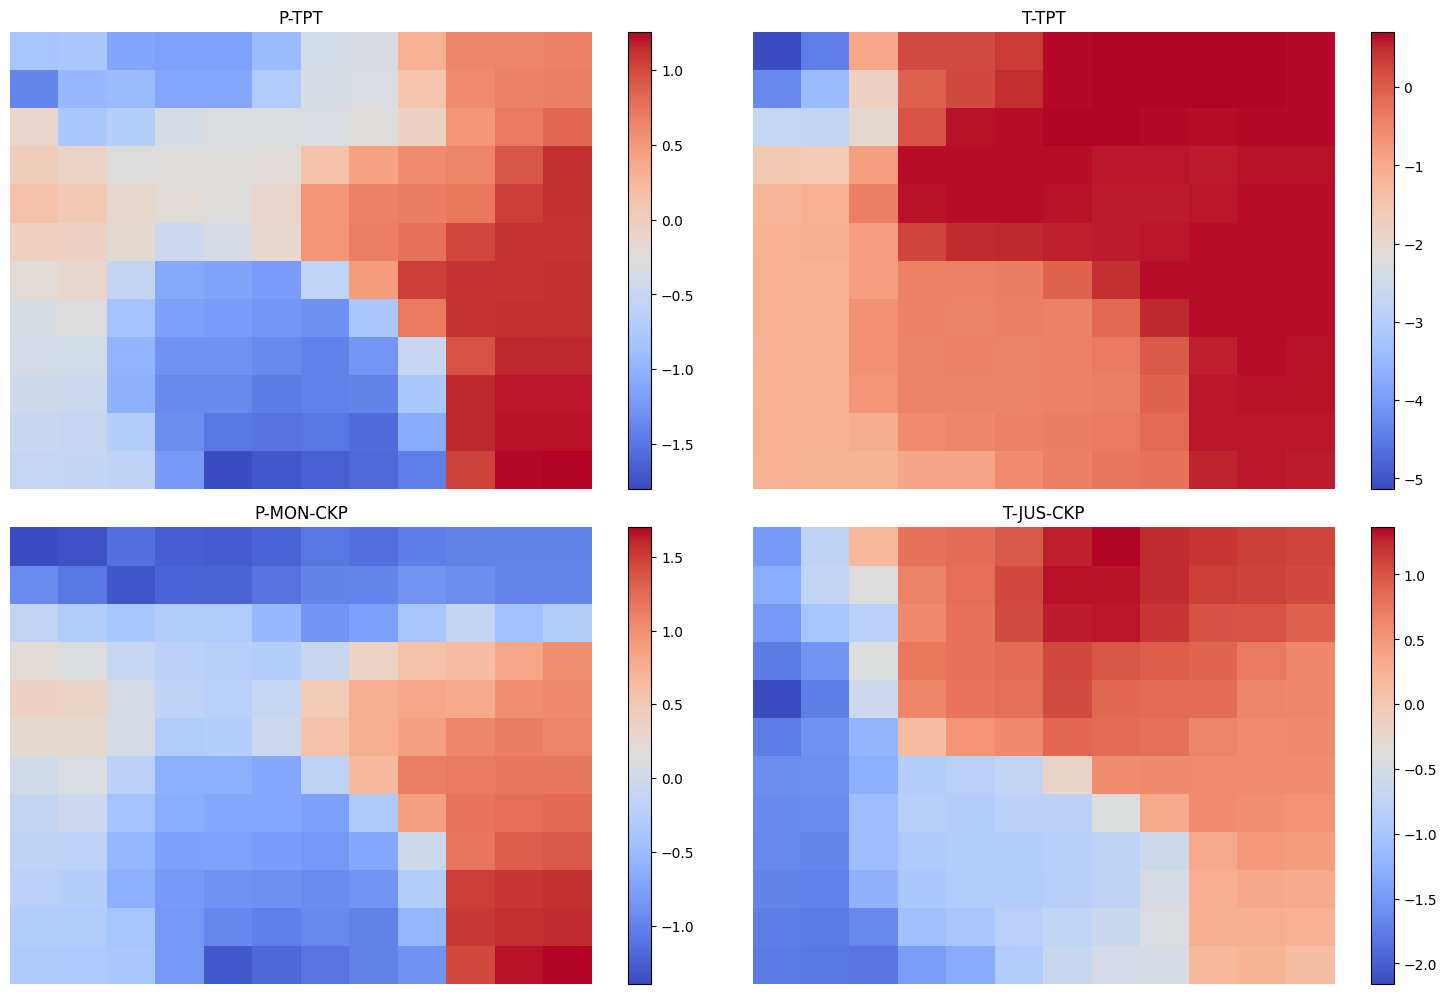

In [25]:
som.plot_map(nrows=3,ncols=2,feature_names=model_input)

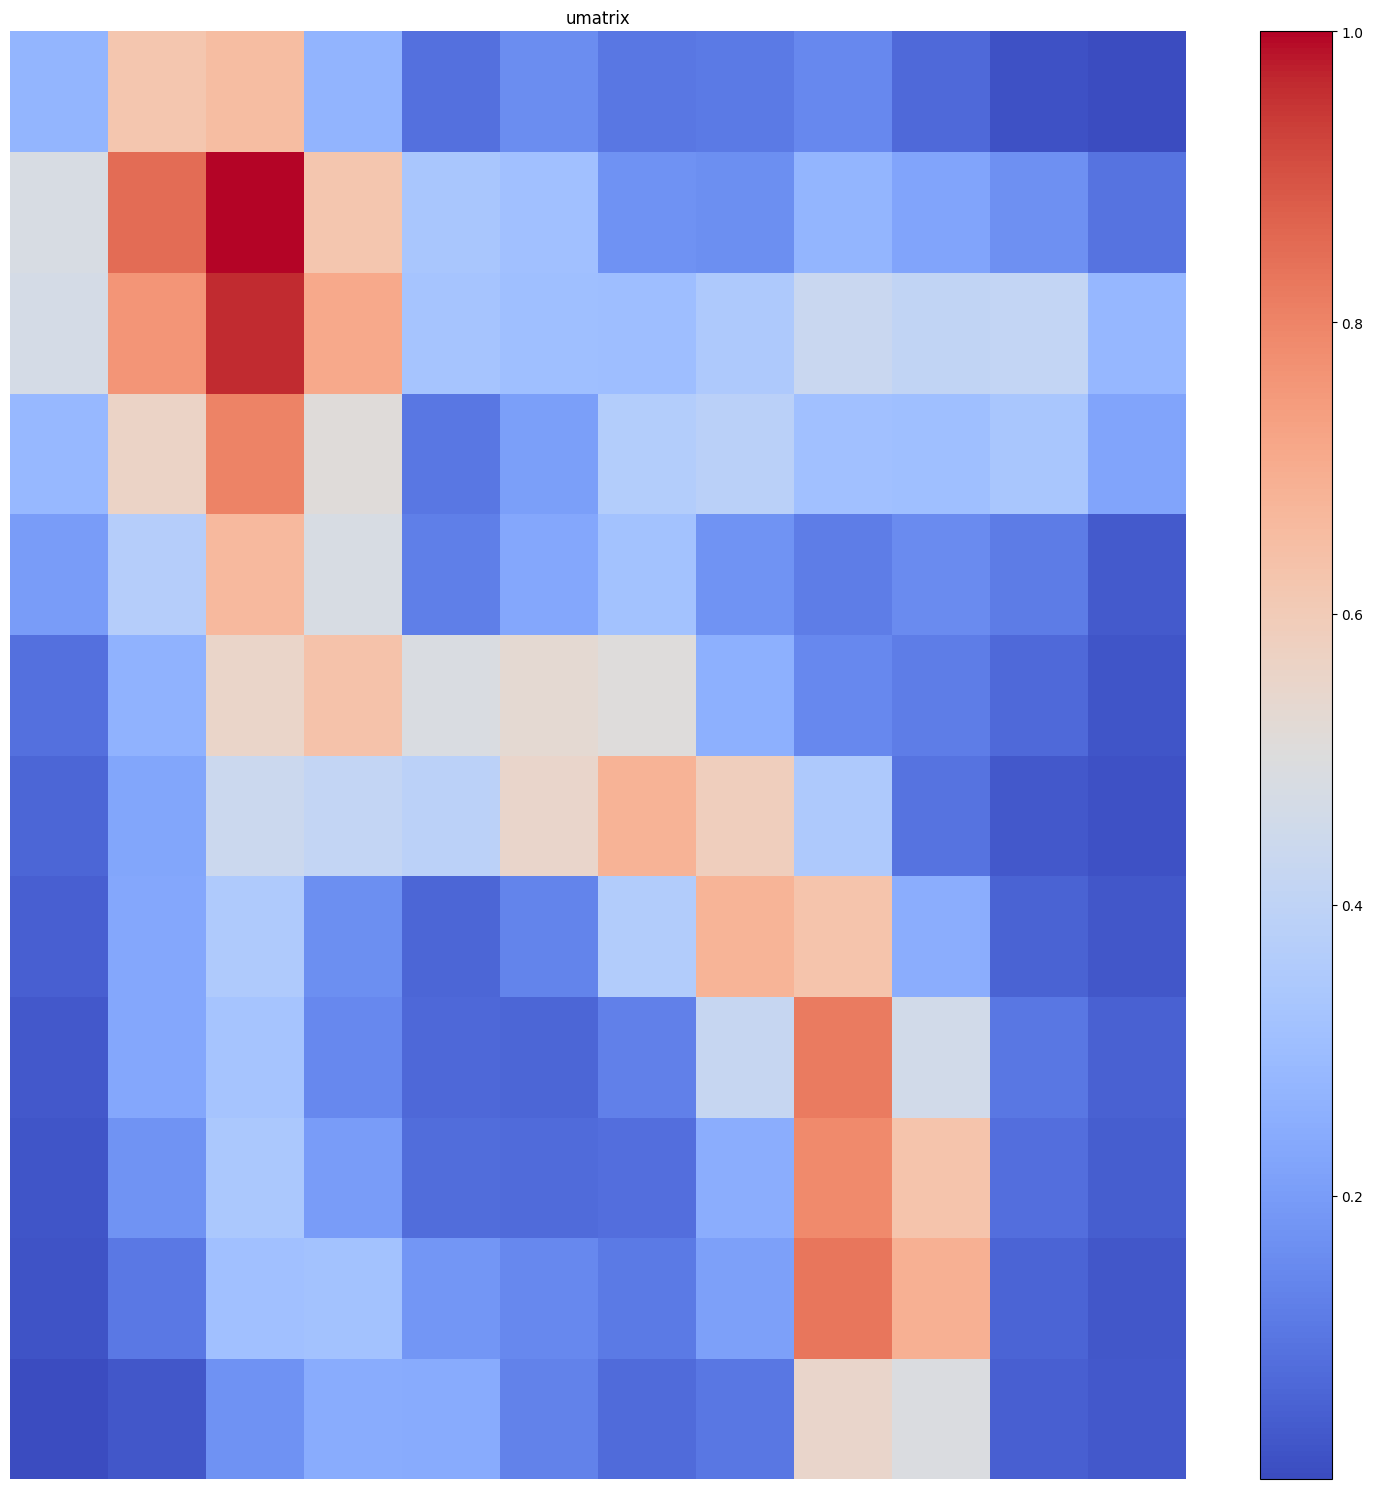

In [26]:
som.plot_umatrix()

# Rotulando

In [27]:
winners = np.array([som.winner(x) for x in X])

In [28]:
winners_reshaped = np.apply_along_axis(lambda x: np.array([x[0], x[1]]), 1, winners)

In [29]:
from sklearn.cluster import KMeans

In [30]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(winners_reshaped)

c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
cluster_labels = kmeans.labels_

In [32]:
df_2["class_prev"] = cluster_labels

C:\Users\marce\AppData\Local\Temp\ipykernel_2152\2933655561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["class_prev"] = cluster_labels


In [33]:
def plot_two_variables(df, var1, var2, binary_column=None):
    """
    Plota um gráfico de dispersão para duas variáveis de um DataFrame, colorindo os pontos conforme uma coluna binária, se fornecida.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - var1: Nome da primeira variável (eixo x).
        - var2: Nome da segunda variável (eixo y).
        - binary_column: Nome da coluna binária usada para colorir os pontos (opcional).
    """
    plt.figure(figsize=(10, 6))

    if binary_column is not None:
        # Obtendo os valores únicos da coluna binária
        classes = df[binary_column].unique()

        # Criando um mapeamento de classe para cor
        colors = {cls: plt.cm.tab10(i) for i, cls in enumerate(classes)}

        # Colorindo os pontos de acordo com as classes
        for cls in classes:
            df_cls = df[df[binary_column] == cls]
            plt.scatter(df_cls[var1], df_cls[var2], color=colors[cls], label=cls, alpha=0.5)
        
        plt.legend(title=binary_column)
    else:
        plt.scatter(df[var1], df[var2], alpha=0.5)

    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'Gráfico de Dispersão: {var1} vs {var2}')
    plt.grid(True)
    plt.show()

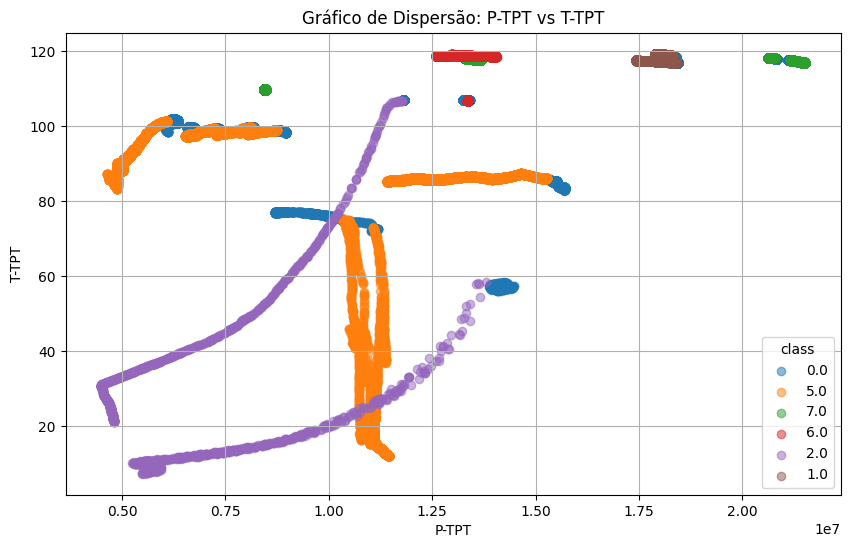

In [34]:
plot_two_variables(df_2, 'P-TPT', 'T-TPT', binary_column="class")

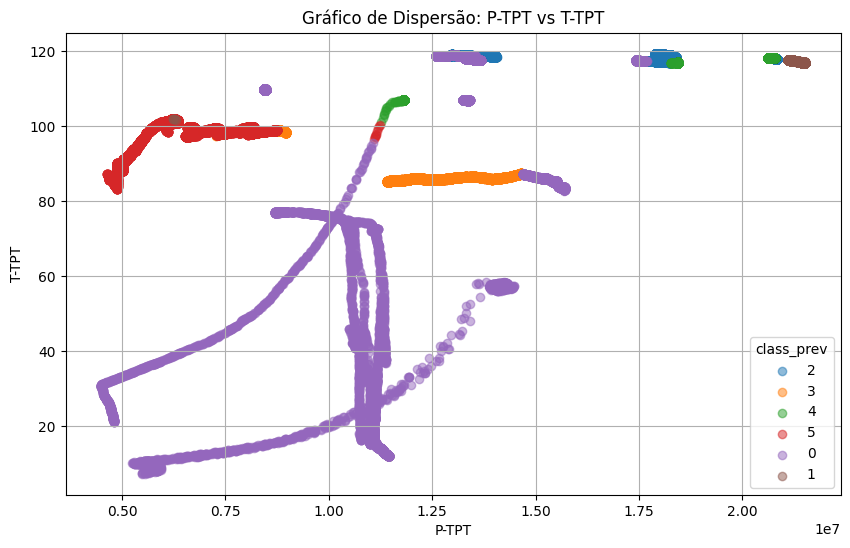

In [39]:
plot_two_variables(df_2, 'P-TPT', 'T-TPT', binary_column="class_prev")

# Salvando modelo SOM para não treinar novamente

In [35]:
import dill

In [36]:
file_path = 'modelo_som_0_2.dill'

# Salvando o modelo SOM usando dill
with open(file_path, 'wb') as f:
    dill.dump(som, f)

In [37]:
# Carregando o modelo SOM salvo
with open(file_path, 'rb') as f:
    som_test = dill.load(f)

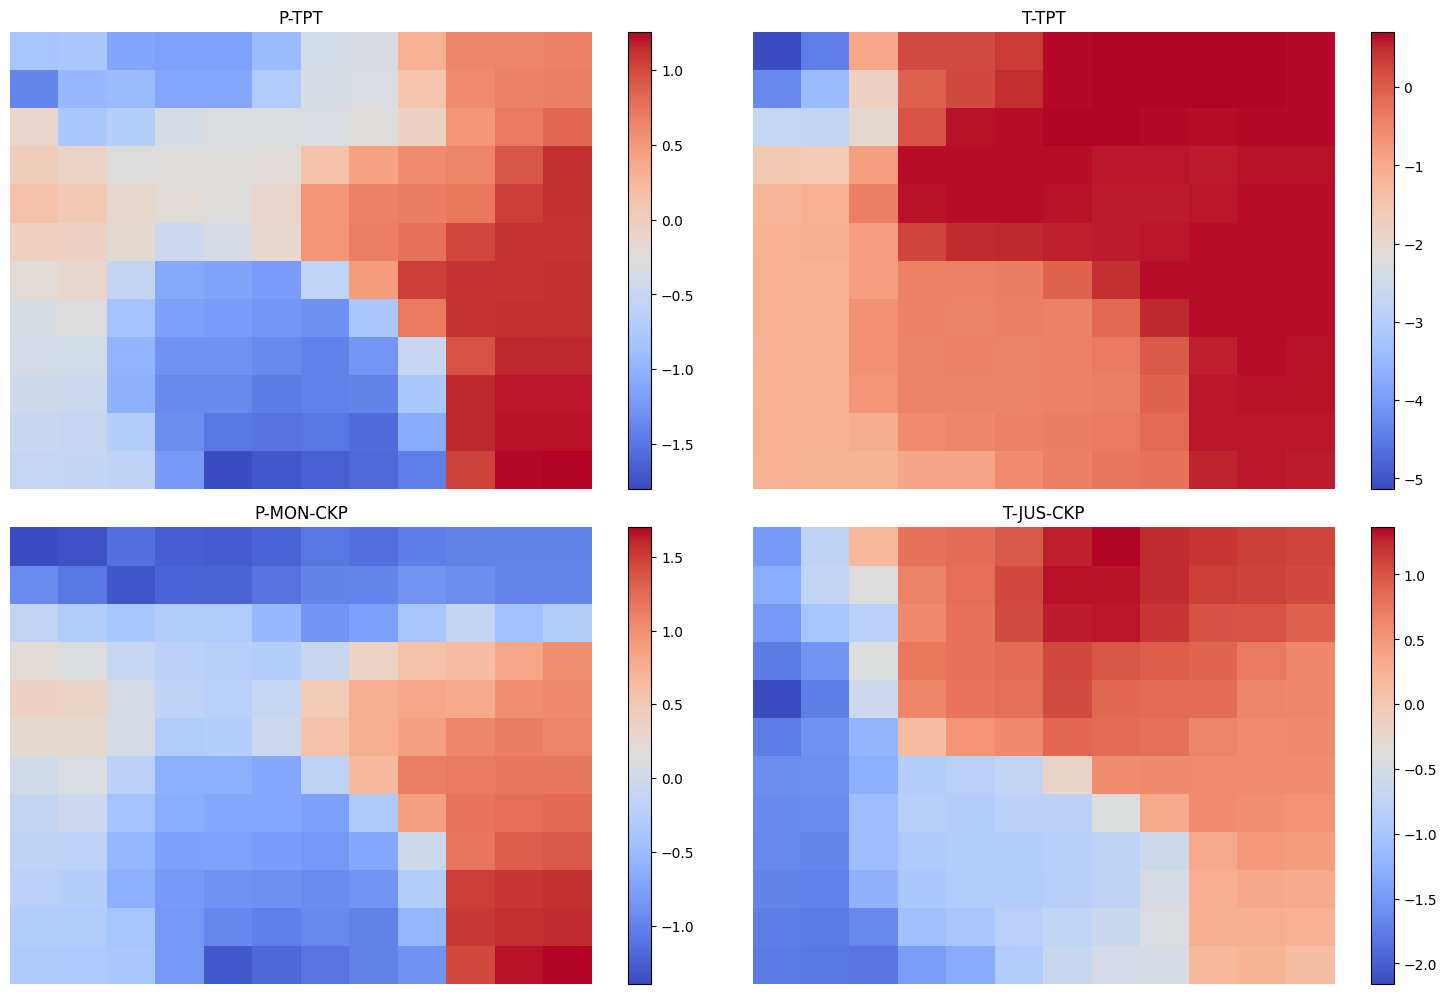

In [38]:
som_test.plot_map(nrows=3,ncols=2,feature_names=model_input)